In [10]:
# Import libraries
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt


import unicodedata
import re
import string
import joblib as joblib
import pickle as pickle

In [11]:
# nltk.download('punkt')
# pip install unidecode
from unidecode import unidecode

In [12]:
# Load data
data_train = pd.read_csv('../../Data Splits/train_data_70_30.csv')
data_val = pd.read_csv('../../Data Splits/val_data_70_30.csv')

In [13]:
X_train = data_train['article']
y_train = data_train['label']

X_val = data_val['article']
y_val = data_val['label']

In [14]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return [self.preprocess(text) for text in X]

    def preprocess(self, text):
        # print(textes)
        text = str(text)
        text = text.lower()
        normalized = unicodedata.normalize("NFD", text)
        text = "".join(c for c in normalized if unicodedata.category(c) != "Mn")
        text = re.sub(r'\[.*?\]', '', text)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)
        return text

In [15]:
#create StopWords
stopwords = pd.read_json('../../Datasets/stopwords-tl.json')
custom_stop_words = stopwords[0].values.tolist()

In [16]:
# Initializing base models

mnb = MultinomialNB()
lr = LogisticRegression()
rf = RandomForestClassifier()
knn = KNeighborsClassifier()
svm = SVC(probability=True)

base_models = [mnb, lr, rf, knn, svm]
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']

In [17]:
# Define the XGBClassifier as meta learner
xgb_model = xgb.XGBClassifier()

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}



In [18]:
# Define the steps in your pipeline
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('gridsearch', GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1))

]

# Create the pipeline
pipeline = Pipeline(steps)

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('gridsearch',
                 GridSear...
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=None, ...),
                              n_jobs=-1,
                              param_grid={'colsample_bytree': [0.8, 0.9, 1.0],
                                          'learning_rate': [0.01, 0.1, 0.2],
                                          'max_depth': [3, 4, 5],
                                          'n_estimators': [100, 200, 300],
                                          'subsample': [0.8, 0.9, 1.0]},
                              scoring='accuracy'))])

In [19]:
best_meta = pipeline.named_steps['gridsearch'].best_estimator_
joblib.dump(pipeline.named_steps['gridsearch'].best_estimator_, '../../Models/70-30 Test/pipeline_xgb_best_estimator.joblib')

['../../Models/70-30 Test/pipeline_xgb_best_estimator.joblib']

In [20]:
print("Best Hyperparameters: ", pipeline.named_steps['gridsearch'].best_params_)
print("Best Accuracy: {:.2f}%".format(pipeline.named_steps['gridsearch'].best_score_ * 100))

Best Hyperparameters:  {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}
Best Accuracy: 93.92%


In [21]:
steps = [
    ('preprocess', TextPreprocessor()),
    ('vectorizer',  TfidfVectorizer(stop_words=custom_stop_words)),
    ('stacking', StackingClassifier(estimators=list(zip(base_names, base_models)), final_estimator=best_meta ,cv=5))
    ]
stack = Pipeline(steps)
stack.fit(X_train, y_train)

Pipeline(steps=[('preprocess', TextPreprocessor()),
                ('vectorizer',
                 TfidfVectorizer(stop_words=['akin', 'aking', 'ako', 'alin',
                                             'am', 'amin', 'aming', 'ang',
                                             'ano', 'anumang', 'apat', 'at',
                                             'atin', 'ating', 'ay', 'bababa',
                                             'bago', 'bakit', 'bawat', 'bilang',
                                             'dahil', 'dalawa', 'dapat', 'din',
                                             'dito', 'doon', 'gagawin',
                                             'gayunman', 'ginagawa', 'ginawa', ...])),
                ('stacking',
                 StackingCl...
                                                                  grow_policy=None,
                                                                  importance_type=None,
                                                                  interaction_constraints=None,
                                                                  learning_rate=0.2,
                                                                  max_bin=None,
                                                                  max_cat_threshold=None,
                                                                  max_cat_to_onehot=None,
                                                                  max_delta_step=None,
                                                                  max_depth=4,
                                                                  max_leaves=None,
                                                                  min_child_weight=None,
                                                                  missing=nan,
                                                                  monotone_constraints=None,
                                                                  multi_strategy=None,
                                                                  n_estimators=200,
                                                                  n_jobs=None,
                                                                  num_parallel_tree=None,
                                                                  random_state=None, ...)))])

Metrics for MNB:
Accuracy: 0.7980295566502463
Precision: 0.720216606498195
Recall: 0.9779411764705882
F1 Score: 0.8295218295218295
AUC: 0.9653162007377208
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.62      0.75       404
           1       0.72      0.98      0.83       408

    accuracy                           0.80       812
   macro avg       0.84      0.80      0.79       812
weighted avg       0.84      0.80      0.79       812



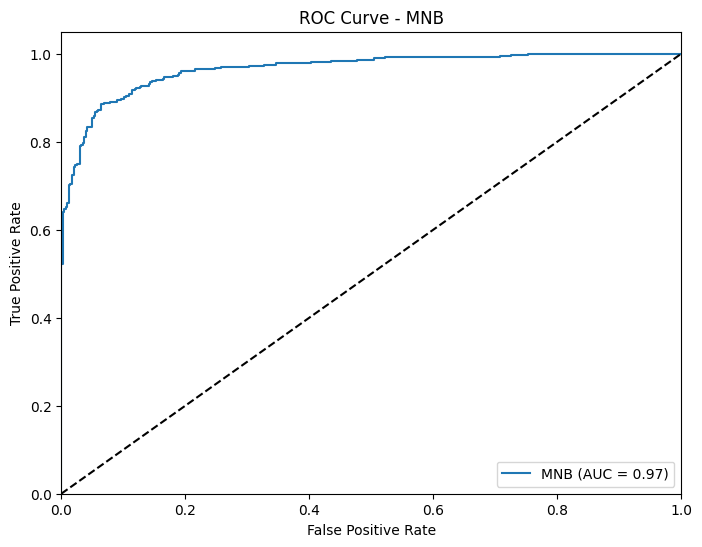

Metrics for LR:
Accuracy: 0.9039408866995073
Precision: 0.9319371727748691
Recall: 0.8725490196078431
F1 Score: 0.9012658227848102
AUC: 0.9754901960784313
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       404
           1       0.93      0.87      0.90       408

    accuracy                           0.90       812
   macro avg       0.91      0.90      0.90       812
weighted avg       0.91      0.90      0.90       812



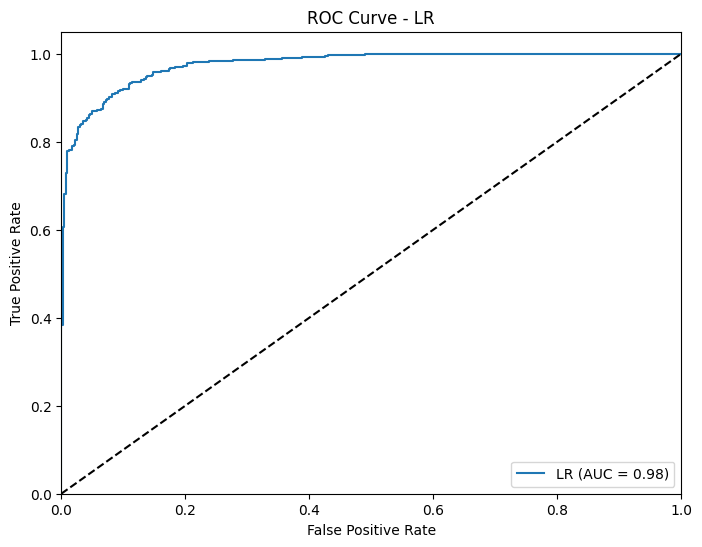

Metrics for RF:
Accuracy: 0.916256157635468
Precision: 0.9292929292929293
Recall: 0.9019607843137255
F1 Score: 0.9154228855721394
AUC: 0.9724659046787031
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       404
           1       0.93      0.90      0.92       408

    accuracy                           0.92       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.92      0.92      0.92       812



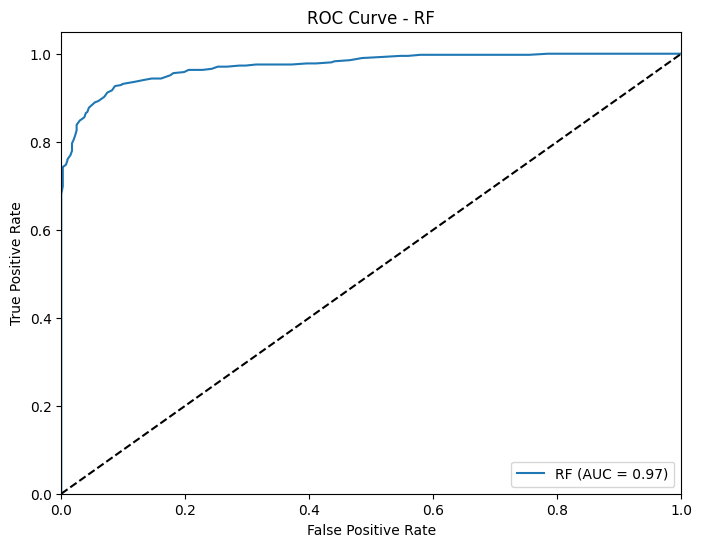

Metrics for KNN:
Accuracy: 0.8448275862068966
Precision: 0.8078602620087336
Recall: 0.9068627450980392
F1 Score: 0.8545034642032333
AUC: 0.9288366336633664
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.78      0.83       404
           1       0.81      0.91      0.85       408

    accuracy                           0.84       812
   macro avg       0.85      0.84      0.84       812
weighted avg       0.85      0.84      0.84       812



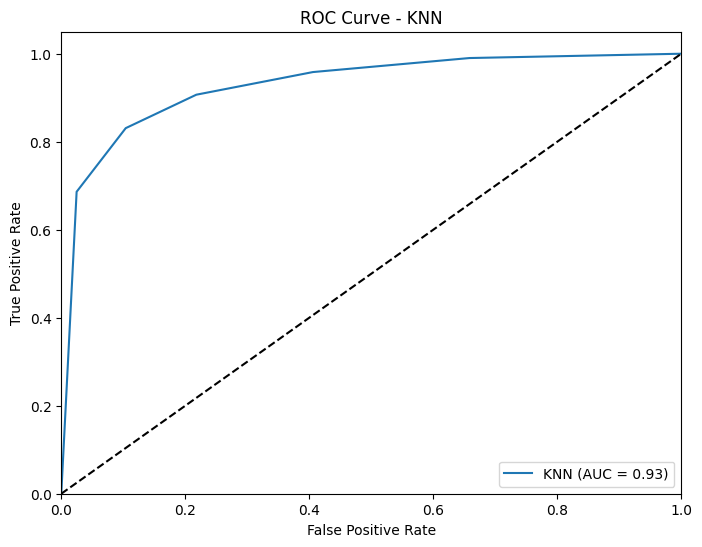

Metrics for SVM:
Accuracy: 0.9211822660098522
Precision: 0.9526315789473684
Recall: 0.8872549019607843
F1 Score: 0.9187817258883249
AUC: 0.9832829790331974
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       404
           1       0.95      0.89      0.92       408

    accuracy                           0.92       812
   macro avg       0.92      0.92      0.92       812
weighted avg       0.92      0.92      0.92       812



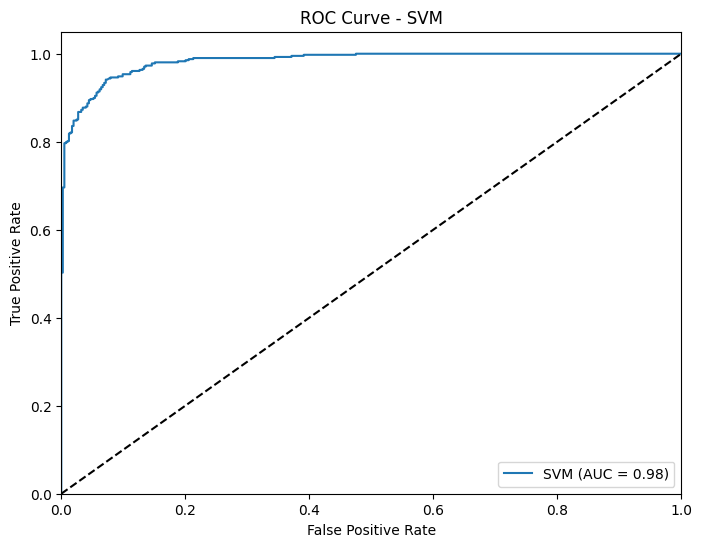

In [22]:
# stack = joblib.load('../../Models/70-30 Test/pipeline_xgb.joblib')

# Create an empty DataFrame for storing metrics
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

# Use TFIDF inside of stacking to vectorize X_val(Evaluation)
vectorized_text = stack.named_steps['vectorizer'].transform(X_val)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(y_val, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_val, y_prob)
    roc_auc = roc_auc_score(y_val, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()

Metrics for Stacking Model:
Accuracy: 0.9532019704433498
Precision: 0.9490291262135923
Recall: 0.9583333333333334
F1 Score: 0.9536585365853658
AUC: 0.9912152980003883
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       404
           1       0.95      0.96      0.95       408

    accuracy                           0.95       812
   macro avg       0.95      0.95      0.95       812
weighted avg       0.95      0.95      0.95       812



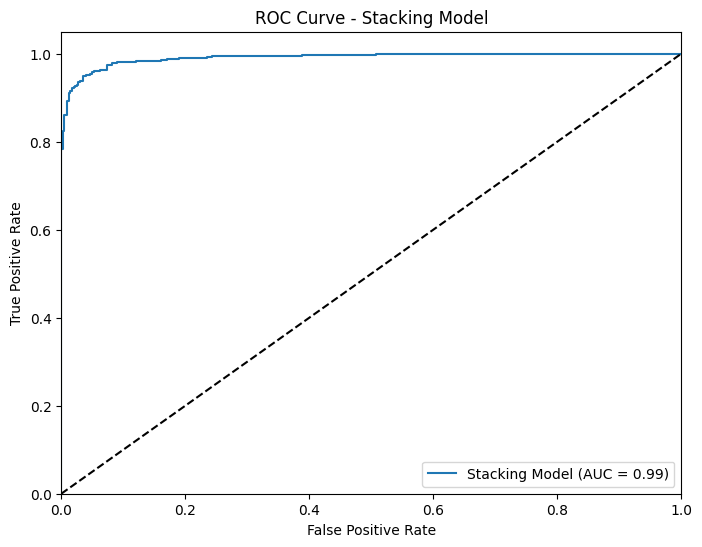

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB              0.79803  0.720217  0.977941  0.829522  0.965316
LR              0.903941  0.931937  0.872549  0.901266   0.97549
RF              0.916256  0.929293  0.901961  0.915423  0.972466
KNN             0.844828   0.80786  0.906863  0.854503  0.928837
SVM             0.921182  0.952632  0.887255  0.918782  0.983283
Stacking Model  0.953202  0.949029  0.958333  0.953659  0.991215


In [23]:
# Evaluate stacking model
stack_y_pred = stack.predict(X_val)
stack_y_prob = stack.predict_proba(X_val)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(y_val, stack_y_pred)
stack_precision = precision_score(y_val, stack_y_pred)
stack_recall = recall_score(y_val, stack_y_pred)
stack_f1 = f1_score(y_val, stack_y_pred)
stack_auc = roc_auc_score(y_val, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(y_val, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(y_val, stack_y_prob)
stack_roc_auc = roc_auc_score(y_val, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)

In [24]:
# Save the model using joblib
joblib.dump(stack, '../../Models/70-30 Test/pipeline_xgb.joblib')

['../../Models/70-30 Test/pipeline_xgb.joblib']